In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc #한글지원
import platform
import seaborn as sns
plt.rc("font",family='Malgun Gothic') #한글_글꼴
plt.rcParams['axes.unicode_minus'] = False #음수표시

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [7]:
for val in ['pb', 'ph', 'fl']:
    globals()['df_{}'.format(val)] = pd.read_csv('./data/data_all_{}.csv'.format(val)).iloc[:,1:]

# 'FIXTURETILTANGLE','ACTUALROTATIONANGLE' 확인

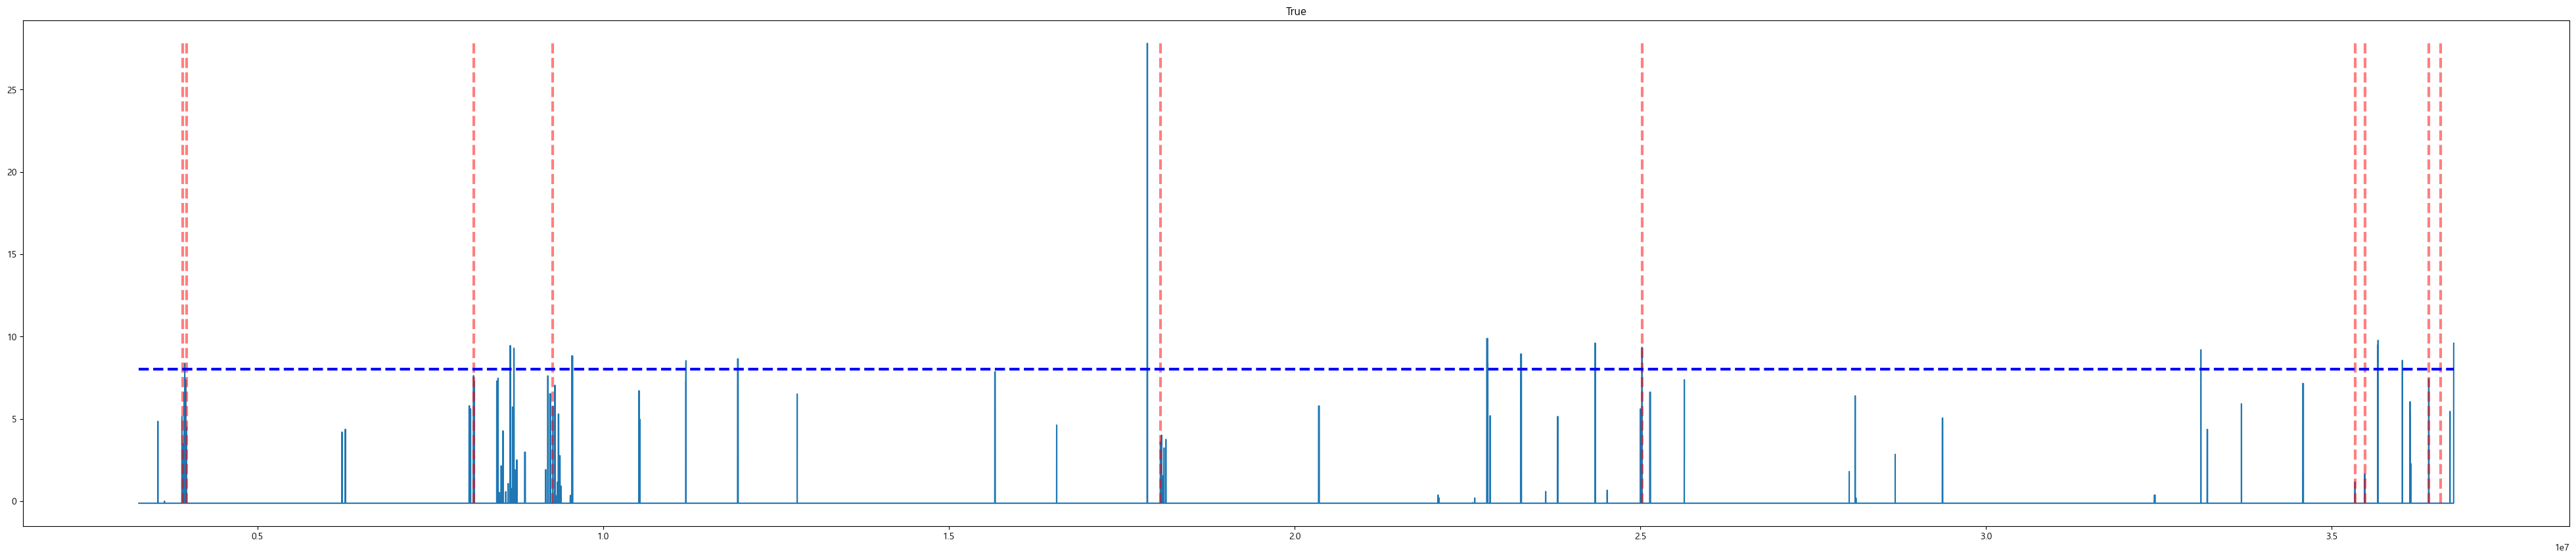

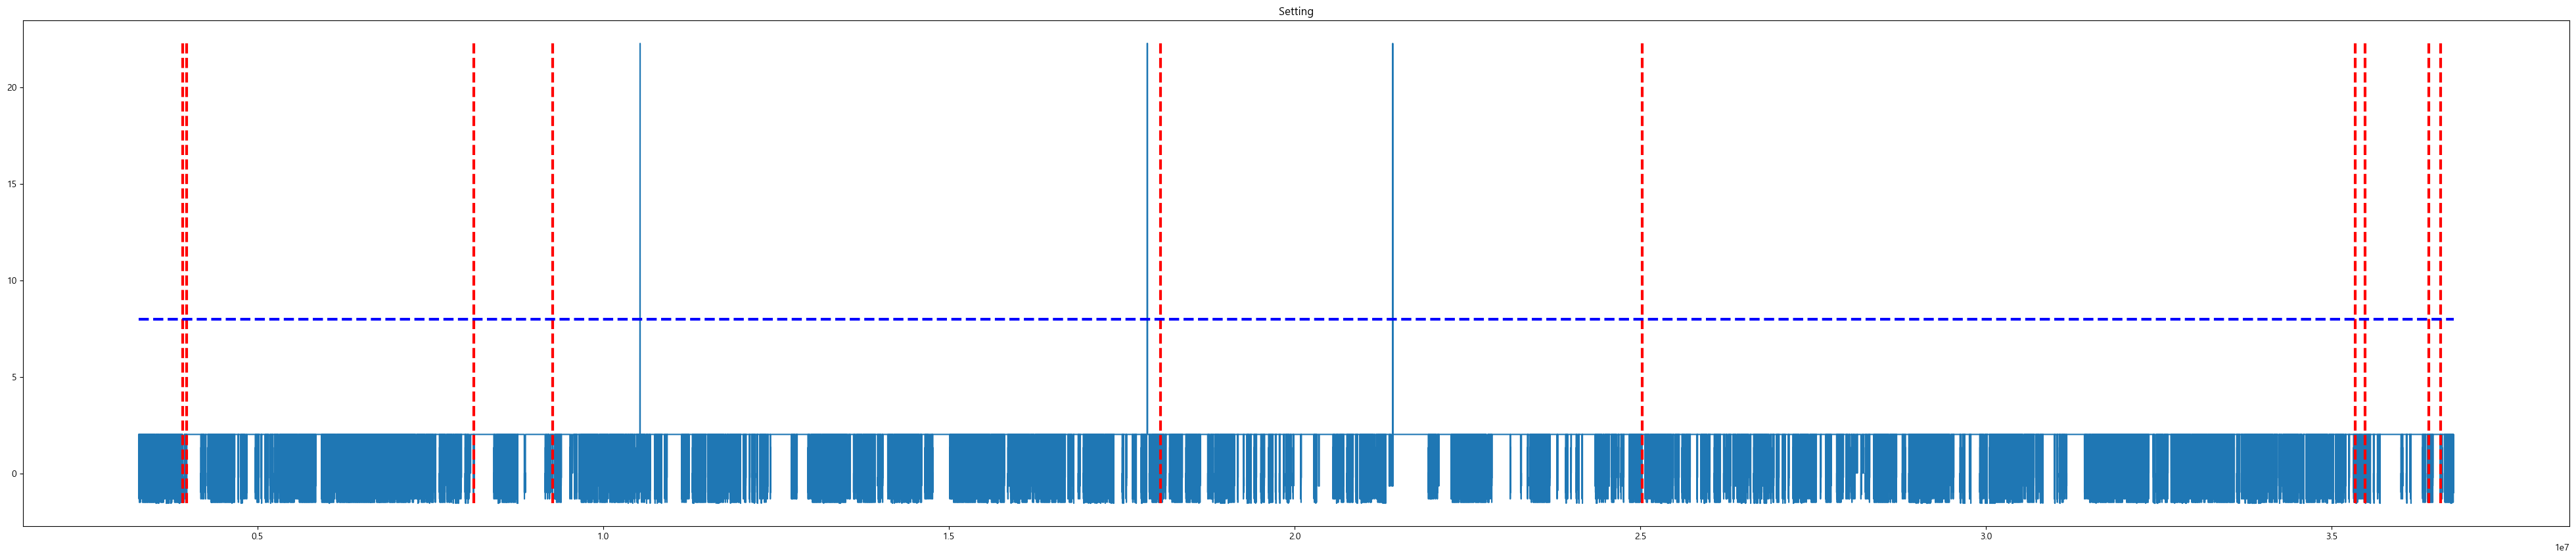

In [39]:
plt.figure(figsize=(50,10))
plt.plot(df_fl['time'], df_fl['ACTUALROTATIONANGLE'])
for i in df_fl[df_fl['fault']==1]['time'].values:
    plt.vlines(i, df_fl['ACTUALROTATIONANGLE'].min(), df_fl['ACTUALROTATIONANGLE'].max(), color='red', linestyle='--', linewidth=3, alpha=0.5) #고장이 발생한 순간
plt.hlines(8, df_fl['time'].min(), df_fl['time'].max(), color='blue', linestyle='--', linewidth=3)
plt.title('True')
plt.show()

plt.figure(figsize=(50,10))
plt.plot(df_fl['time'], df_fl['FIXTURETILTANGLE'])
for i in df_fl[df_fl['fault']==1]['time'].values:
    plt.vlines(i, df_fl['FIXTURETILTANGLE'].min(), df_fl['FIXTURETILTANGLE'].max(), color='red', linestyle='--', linewidth=3) #고장이 발생한 순간
plt.hlines(8, df_fl['time'].min(), df_fl['time'].max(), color='blue', linestyle='--', linewidth=3)
plt.title('Setting')
plt.show()

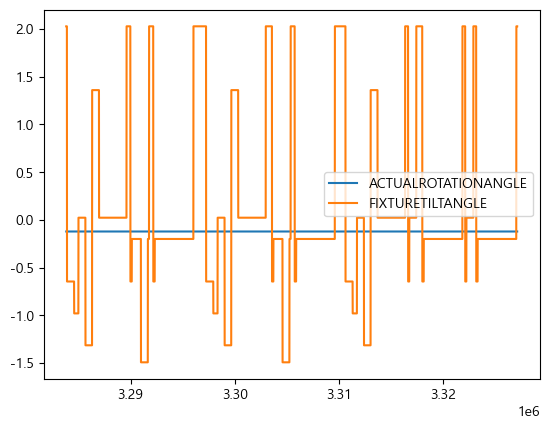

In [49]:
plt.plot(df_fl['time'][:10000], df_fl['ACTUALROTATIONANGLE'][:10000], label='ACTUALROTATIONANGLE')
plt.plot(df_fl['time'][:10000], df_fl['FIXTURETILTANGLE'][:10000], label='FIXTURETILTANGLE')
plt.legend()

# xgbRegressor

In [71]:
len(df_ph.columns)

26

In [64]:
df_merge = df_fl.copy()
df_merge['FIXTURESHUTTERPOSITION'].fillna(method='ffill', inplace=True)
df_merge = df_merge.iloc[:, 7:]
df_merge = df_merge[df_merge.columns.difference(['ROTATIONSPEED', 'FIXTURESHUTTERPOSITION', 'ETCHAUX2SOURCETIMER', 'ETCHAUXSOURCETIMER'])] #corr=1
# df_merge

In [65]:
combination_cols = [#['ETCHAUX2SOURCETIMER', 'ETCHAUXSOURCETIMER'],
    ['ETCHBEAMVOLTAGE', 'ETCHSUPPRESSORCURRENT'],
    ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE'],
    ['ETCHBEAMVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE'],
    ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE']
]

In [66]:
df_result = pd.DataFrame()
ss = StandardScaler()
a = df_merge.iloc[:, :-2]
b = df_merge.iloc[:, -2]

for col in tqdm(combination_cols):
    ### 훈련 독립, 종속변수 정의
    data = a[a.columns.difference(col)]
    target = b.to_numpy()
    
    ### StandardScaler 정규화
    ss.fit(data)
    data = ss.transform(data)
    
    ### 훈련:검증:테스트(7:1.5:1.5)데이터 분할
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.25)
    
    ### 모델 정의 및 훈련
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(train_input, train_target)
    
    ### 결정계수 및 과적합 여부 계산
    train_score = xgb_model.score(train_input, train_target)
    test_score = xgb_model.score(test_input, test_target)
    
    pred = xgb_model.predict(test_input)
    
    mse = mean_squared_error(test_target, pred)
    
    
    ## 과적합 여부 확인 
    if train_score<test_score:
        underfit = "0" # 과소적합 발생
    else:
        underfit = "1" # 과소적합 미발생
    
    if (train_score-test_score)/train_score*100 < 10:
        overfit = "3" # 과대적합 미발생
    else:
        overfit = "2" # 과대적합 발생
    
    result_dict = {"use_col": [list(a[a.columns.difference(col)].columns)], "train_score": train_score, "test_score": test_score, "underfit": underfit, "overfit": overfit, 'shape':[data.shape], 'mse':mse}
    temp = pd.DataFrame(result_dict)
    df_result = pd.concat([df_result, temp], axis=0)
df_result

100%|██████████| 4/4 [00:56<00:00, 14.09s/it]


,use_col,train_score,test_score,underfit,overfit,shape,mse
0,"[ACTUALROTATIONANGLE, ACTUALSTEPDURATION, ETCH...",0.867733,0.866816,1,3,"(4633723, 11)",1.006150e+12
0,"[ACTUALROTATIONANGLE, ACTUALSTEPDURATION, ETCH...",0.879445,0.878390,1,3,"(4633723, 11)",9.187078e+11
0,"[ACTUALROTATIONANGLE, ACTUALSTEPDURATION, ETCH...",0.861191,0.860261,1,3,"(4633723, 9)",1.055664e+12
0,"[ACTUALROTATIONANGLE, ACTUALSTEPDURATION, ETCH...",0.879000,0.878265,1,3,"(4633723, 10)",9.196576e+11


In [67]:
for i in range(4):
    print(df_result.iloc[i,-1])

1006149961813.84
918707831799.4318
1055663950815.0939
919657582595.858


In [37]:
df_result

,use_col,train_score,val_score,test_score,underfit,overfit
0,"[ETCHBEAMVOLTAGE, ETCHSUPPRESSORCURRENT]",0.925053,0.924069,0.923844,1,3
0,"[ETCHBEAMCURRENT, ETCHSUPPRESSORVOLTAGE]",0.937446,0.937039,0.936461,1,3
0,"[ETCHBEAMVOLTAGE, ETCHSUPPRESSORCURRENT, ETCHS...",0.918206,0.917705,0.917057,1,3
0,"[ETCHBEAMCURRENT, ETCHSUPPRESSORVOLTAGE, ETCHS...",0.937338,0.937038,0.936465,1,3


In [38]:
df_test = pd.read_csv('./data/01_M02_DC_test.csv')

In [46]:
test1 = df_test.copy()
test1['FIXTURESHUTTERPOSITION'].fillna(method='ffill', inplace=True)
test1 = test1.iloc[:, 7:]
test1 = test1[test1.columns.difference(['ROTATIONSPEED', 'FIXTURESHUTTERPOSITION', 'ETCHAUX2SOURCETIMER', 'ETCHAUXSOURCETIMER'])] #corr=1
test1 = test1[test1.columns.difference(['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE'])] #corr=0.85~0.9
test1

,ACTUALROTATIONANGLE,ACTUALSTEPDURATION,ETCHBEAMVOLTAGE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,ETCHSOURCEUSAGE,ETCHSUPPRESSORCURRENT,FIXTURETILTANGLE,FLOWCOOLPRESSURE,IONGAUGEPRESSURE
0,-0.122455,-0.304990,0.709876,1.411886,0.364281,-0.184694,1.818214,0.022131,-0.106780,0.026573
1,-0.122455,-0.304990,0.710330,1.411886,0.360776,-0.184691,1.823373,0.022131,-0.109982,0.026573
2,-0.122455,-0.304990,0.710501,1.410382,0.360776,-0.184688,1.821307,0.022131,-0.100334,0.026573
3,-0.122455,-0.304990,0.710330,1.410382,0.360776,-0.184684,1.812366,0.022131,-0.103557,0.026573
4,-0.122455,-0.304990,0.709819,1.410382,0.358499,-0.184681,1.823029,0.022131,-0.108065,0.026573
...,...,...,...,...,...,...,...,...,...,...
1703509,-0.122446,-0.680581,-0.943288,-0.053538,0.359727,1.012377,-0.845862,-0.200727,0.268670,0.007607
1703510,-0.122446,-0.680581,-0.943345,-0.058299,0.359727,1.012380,-0.846893,-0.200727,0.268670,0.007607
1703511,-0.122446,-0.680581,-0.943345,-0.058299,0.359727,1.012383,-0.846550,-0.200727,0.268670,0.007607
1703512,-0.122446,-0.680581,-0.943402,-0.058299,0.364281,1.012387,-0.847581,-0.200727,0.268670,0.007607


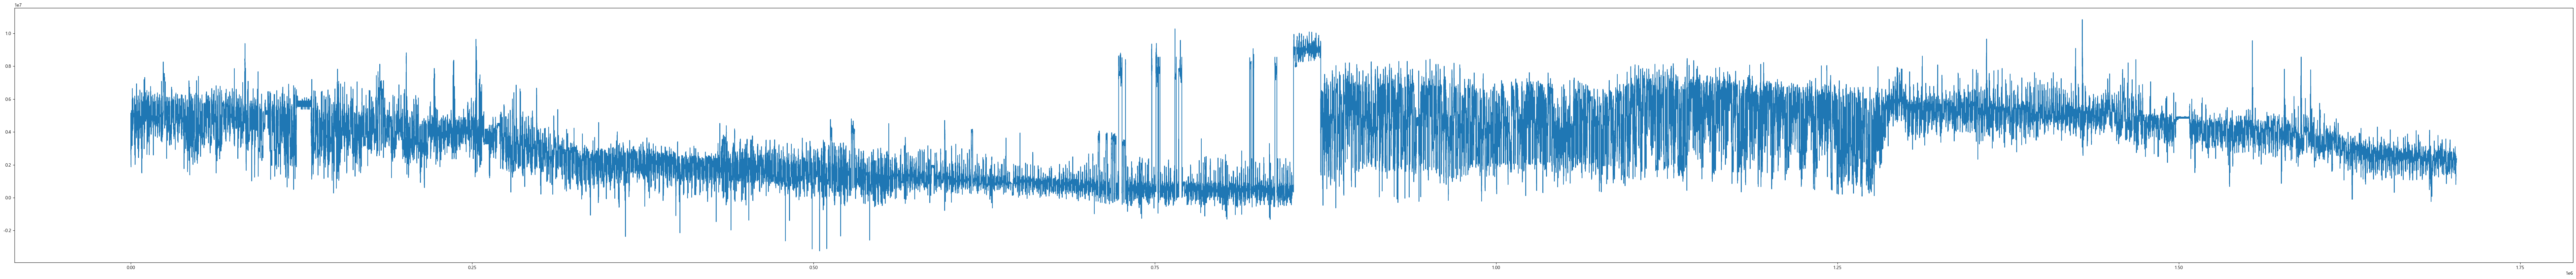

In [52]:
data1 = ss.transform(test1)

pred = xgb_model.predict(data1)

plt.figure(figsize=(100,10))
plt.plot(range(len(data1)), pred)

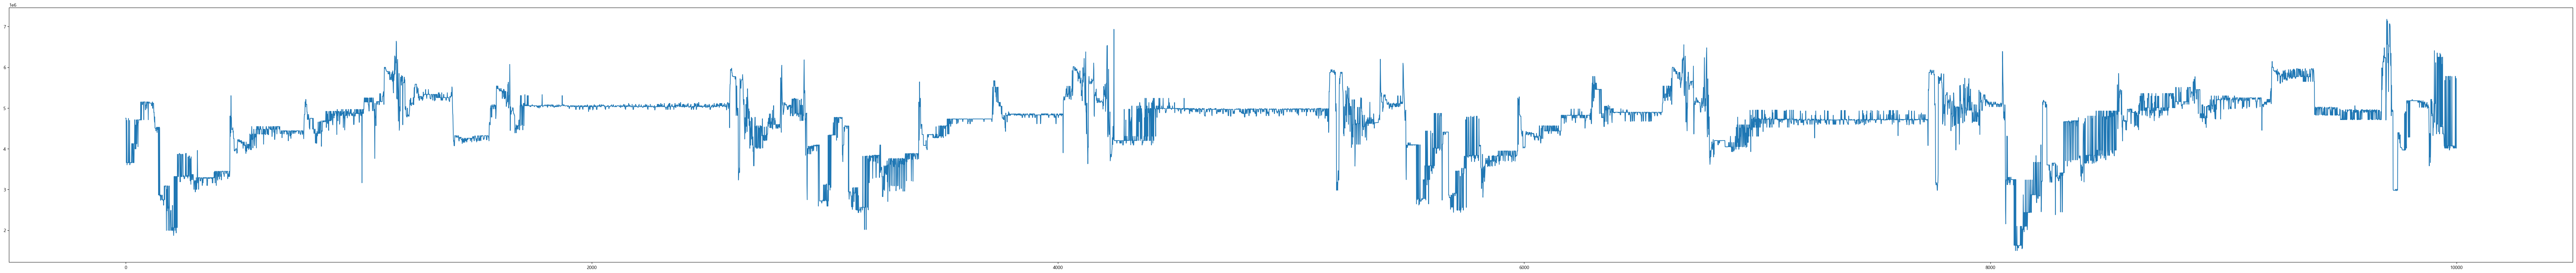

In [54]:
plt.figure(figsize=(100,10))
plt.plot(range(len(data1[:10000])), pred[:10000])

# XGB + DMatrix

In [68]:
from sklearn.preprocessing import MinMaxScaler
y = df_merge.iloc[:, -2]
mm = MinMaxScaler()
mm.fit(y)

aa = np.unique(mm.transform(y), return_counts=True)
aa[0]

array([0.00000000e+00, 2.17787346e-07, 4.35574692e-07, ...,
       9.99999129e-01, 9.99999564e-01, 1.00000000e+00])

In [69]:
## RUL (y) predict

import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 데이터셋 로드
col = ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE']
X = df_merge.iloc[:, :-2]
X = X[X.columns.difference(col)]
y = df_merge.iloc[:, -2].to_numpy().reshape(-1,1) #ttf
categorical_variable = df_merge.iloc[:, -1] #fault

# 정규화
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)

# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train, X_test, Y_train, Y_test, cat_train, cat_test = train_test_split(X, y, categorical_variable, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 훈련
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=Y_train, missing=None)
dtest = xgb.DMatrix(X_test, label=Y_test, missing=None)

model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, 'test')], early_stopping_rounds=10)

# 모델을 사용하여 테스트 데이터에 대한 예측 수행
Y_pred = model.predict(dtest)

# 예측 결과 평가
mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)

[0]	test-rmse:2485182.57068
[1]	test-rmse:2285253.09521
[2]	test-rmse:2138635.26869
[3]	test-rmse:2028614.89920
[4]	test-rmse:1956318.47715
[5]	test-rmse:1814457.39057
[6]	test-rmse:1740385.82593
[7]	test-rmse:1667012.69341
[8]	test-rmse:1621505.04871
[9]	test-rmse:1584548.28325
[10]	test-rmse:1548739.11283
[11]	test-rmse:1526862.39228
[12]	test-rmse:1504800.77897
[13]	test-rmse:1488644.85948
[14]	test-rmse:1452234.90976
[15]	test-rmse:1433818.31425
[16]	test-rmse:1418663.08283
[17]	test-rmse:1399285.84849
[18]	test-rmse:1378987.91671
[19]	test-rmse:1347552.80724
[20]	test-rmse:1324034.98350
[21]	test-rmse:1302637.31779
[22]	test-rmse:1292243.07371
[23]	test-rmse:1275556.20525
[24]	test-rmse:1272118.19547
[25]	test-rmse:1265419.68992
[26]	test-rmse:1252099.43929
[27]	test-rmse:1244376.89162
[28]	test-rmse:1232883.32602
[29]	test-rmse:1215637.81587
[30]	test-rmse:1207850.87518
[31]	test-rmse:1197822.69889
[32]	test-rmse:1192656.11406
[33]	test-rmse:1186091.34856
[34]	test-rmse:1176245.9

In [ ]:
## Fault (categorical) predict

import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 데이터셋 로드
col = ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE']
X = df_merge.iloc[:, :-2]
X = X[X.columns.difference(col)]
y = df_merge.iloc[:, -2].to_numpy().reshape(-1,1) #ttf
categorical_variable = df_merge.iloc[:, -1] #fault

# 정규화
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)

mm = MinMaxScaler()
mm.fit(y)
y = mm.transform(y)

# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train, X_test, Y_train, Y_test, cat_train, cat_test = train_test_split(X, y, categorical_variable, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 훈련
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=Y_train, missing=None)
dtest = xgb.DMatrix(X_test, label=Y_test, missing=None)

model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, 'test')], early_stopping_rounds=10)

# 모델을 사용하여 테스트 데이터에 대한 예측 수행
Y_pred = model.predict(dtest)

# 예측 결과 평가
mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)

[0]	test-rmse:0.24096
[1]	test-rmse:0.22158
[2]	test-rmse:0.20736
[3]	test-rmse:0.19669
[4]	test-rmse:0.18968
[5]	test-rmse:0.17593
[6]	test-rmse:0.16875
[7]	test-rmse:0.16163
[8]	test-rmse:0.15722
[9]	test-rmse:0.15364
[10]	test-rmse:0.15016
[11]	test-rmse:0.14804
[12]	test-rmse:0.14590
[13]	test-rmse:0.14434
[14]	test-rmse:0.14081
[15]	test-rmse:0.13902
[16]	test-rmse:0.13755
[17]	test-rmse:0.13567
[18]	test-rmse:0.13371
[19]	test-rmse:0.13066
[20]	test-rmse:0.12838
[21]	test-rmse:0.12630
[22]	test-rmse:0.12529
[23]	test-rmse:0.12368
[24]	test-rmse:0.12334
[25]	test-rmse:0.12269
[26]	test-rmse:0.12140
[27]	test-rmse:0.12065
[28]	test-rmse:0.11954
[29]	test-rmse:0.11787
[30]	test-rmse:0.11711
[31]	test-rmse:0.11614
[32]	test-rmse:0.11564
[33]	test-rmse:0.11500
[34]	test-rmse:0.11405
[35]	test-rmse:0.11374
[36]	test-rmse:0.11331
[37]	test-rmse:0.11275
[38]	test-rmse:0.11164
[39]	test-rmse:0.11108
[40]	test-rmse:0.11053
[41]	test-rmse:0.10930
[42]	test-rmse:0.10896
[43]	test-rmse:0.1082

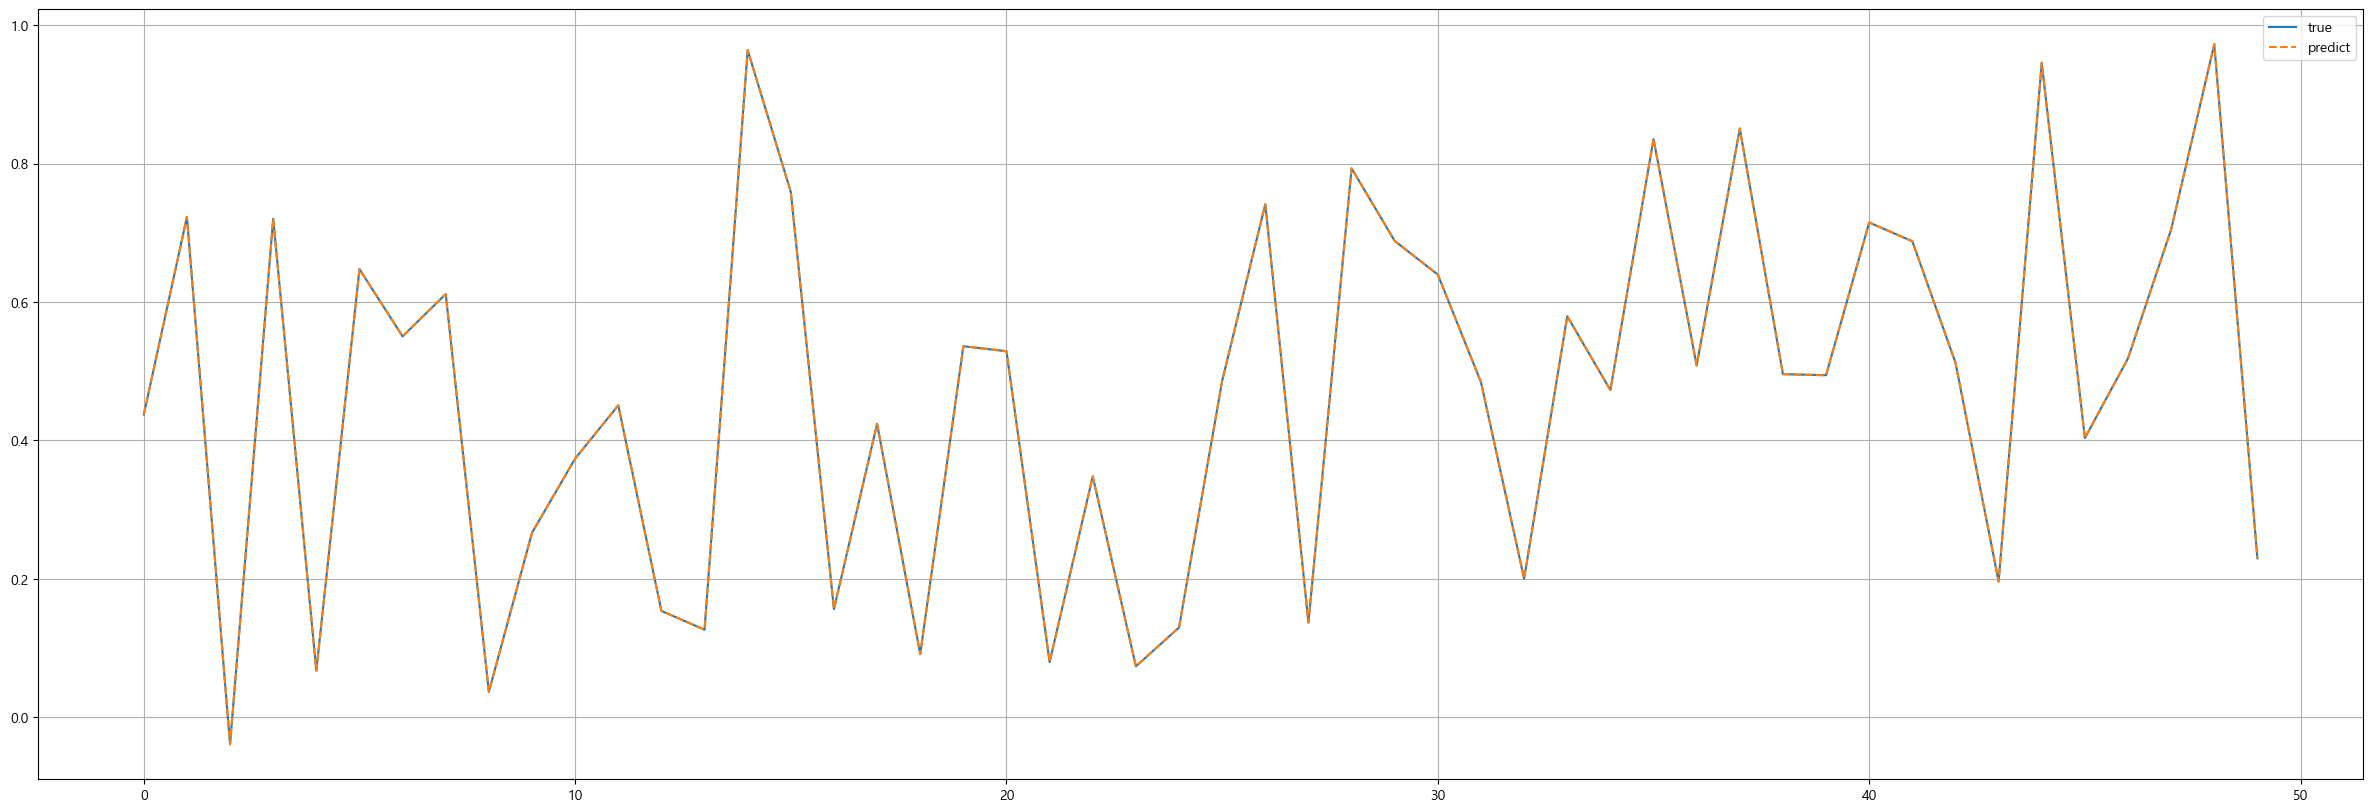

In [206]:
plt.figure(figsize=(30,10))
plt.plot(range(len(Y_test[:50])), Y_pred[:50], label='true')
plt.plot(range(len(Y_test[:50])), Y_pred[:50], linestyle='--', label='predict')
plt.legend()
plt.grid()

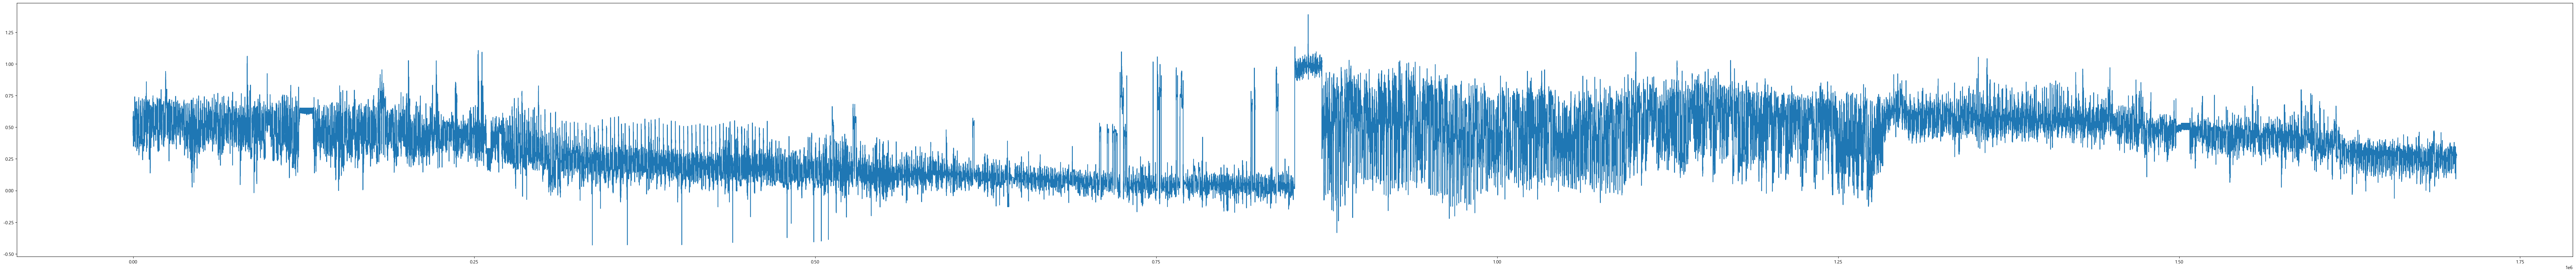

In [207]:
data1 = ss.transform(test1)
data2 = xgb.DMatrix(data1, missing=None)

pred = model.predict(data2)

plt.figure(figsize=(100,10))
plt.plot(range(len(data1)), pred)

In [103]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, cat_train.shape, cat_test.shape

((3018231, 10), (754558, 10), (3018231, 1), (754558, 1), (3018231,), (754558,))

In [123]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 데이터셋 로드
col = ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE']
X = df_merge.iloc[:, :-2]
X = X[X.columns.difference(col)]
y = df_merge.iloc[:, -2].to_numpy().reshape(-1,1) #ttf
categorical_variable = df_merge.iloc[:, -1] #fault

# 정규화
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)

mm = MinMaxScaler()
mm.fit(y)
y = mm.transform(y)

# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train, X_test, Y_train, Y_test, cat_train, cat_test = train_test_split(X, y, categorical_variable, test_size=0.2, random_state=42, stratify=categorical_variable)

# XGBoost 모델 생성 및 훈련
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

dtrain = xgb.DMatrix(X_train, label=cat_train, missing=None)
dtest = xgb.DMatrix(X_test, label=cat_test, missing=None)

model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, 'test')], early_stopping_rounds=10)

Y_pred = model.predict(dtest)

# 모델을 사용하여 테스트 데이터에 대한 예측 수행
# cf_matrix = confusion_matrix(cat_test, Y_pred)

# # 예측 결과 평가
# sns.heatmap(cf_matrix, annot=True)

[0]	test-logloss:0.09192
[1]	test-logloss:0.06700
[2]	test-logloss:0.04906
[3]	test-logloss:0.03603
[4]	test-logloss:0.02653
[5]	test-logloss:0.01957
[6]	test-logloss:0.01445
[7]	test-logloss:0.01068
[8]	test-logloss:0.00790
[9]	test-logloss:0.00585
[10]	test-logloss:0.00433
[11]	test-logloss:0.00321
[12]	test-logloss:0.00238
[13]	test-logloss:0.00176
[14]	test-logloss:0.00131
[15]	test-logloss:0.00097
[16]	test-logloss:0.00072
[17]	test-logloss:0.00054
[18]	test-logloss:0.00040
[19]	test-logloss:0.00030
[20]	test-logloss:0.00023
[21]	test-logloss:0.00017
[22]	test-logloss:0.00013
[23]	test-logloss:0.00010
[24]	test-logloss:0.00008
[25]	test-logloss:0.00006
[26]	test-logloss:0.00005
[27]	test-logloss:0.00004
[28]	test-logloss:0.00003
[29]	test-logloss:0.00003
[30]	test-logloss:0.00002
[31]	test-logloss:0.00002
[32]	test-logloss:0.00002
[33]	test-logloss:0.00002
[34]	test-logloss:0.00002
[35]	test-logloss:0.00002
[36]	test-logloss:0.00001
[37]	test-logloss:0.00001
[38]	test-logloss:0.00

In [197]:
Y_pred2 = (Y_pred > 3.687594585244369e-07).astype(int)
np.unique(Y_pred2, return_counts=True)

(array([0, 1]), array([296717, 457841], dtype=int64))

In [196]:
np.quantile(Y_pred, .100)

1.7660808282471407e-07

In [119]:
accuracy = accuracy_score(cat_test, (Y_pred > 0.5).astype(int))
accuracy

1.0

# ElasticNet

In [200]:
from sklearn.linear_model import ElasticNet

# 종속 변수와 독립 변수 분리
col = ['ETCHBEAMCURRENT', 'ETCHSUPPRESSORVOLTAGE', 'FLOWCOOLFLOWRATE']
X = df_merge.iloc[:, :-2]
X = X[X.columns.difference(col)]
Y_continuous = df_merge.iloc[:, -2].to_numpy().reshape(-1,1) #ttf
Y_categorical = df_merge.iloc[:, -1] #fault

# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train, X_test, Y_train_continuous, Y_test_continuous, Y_train_categorical, Y_test_categorical = train_test_split(
    X, Y_continuous, Y_categorical, test_size=0.2, random_state=42)

# ElasticNet 모델 생성 및 훈련 (연속형 종속 변수)
elasticnet_continuous = ElasticNet(alpha=1.0, l1_ratio=0.5)
elasticnet_continuous.fit(X_train, Y_train_continuous)

# ElasticNet 모델 생성 및 훈련 (범주형 종속 변수)
elasticnet_categorical = ElasticNet(alpha=1.0, l1_ratio=0.5)
elasticnet_categorical.fit(X_train, Y_train_categorical)

# 모델을 사용하여 테스트 데이터에 대한 예측 수행
Y_pred_continuous = elasticnet_continuous.predict(X_test)
Y_pred_categorical = elasticnet_categorical.predict(X_test)

# 예측 결과 평가
mse = mean_squared_error(Y_test_continuous, Y_pred_continuous)
accuracy = accuracy_score(Y_test_categorical, (Y_pred_categorical > 0.5).astype(int))

print("Mean Squared Error (Continuous):", mse)
print("Accuracy (Categorical):", accuracy)

Mean Squared Error (Continuous): 6743038590857.877
Accuracy (Categorical): 1.0
